## ⚕️ Chest X-Ray Pneumonia Classification

Given *images of chest X-rays*, let's try to predict whether **pneumonia is present** in a given image.

We will use a pre-trained Tensorflow CNN (MobileNetV2) to make our predictions.

Data source: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

import tensorflow as tf

2025-06-02 09:02:23.688239: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_dir = 'archive/train'
test_dir = 'archive/test'
val_dir = 'archive/val'

In [3]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

BATCH_SIZE = 32

### Creating Data Generators

In [4]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    brightness_range = (1.2, 1.5),
    horizontal_flip = True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

In [5]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'binary',
    batch_size = BATCH_SIZE
)

val_data = train_datagen.flow_from_directory(
    val_dir,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'binary',
    batch_size = BATCH_SIZE
)

test_data = train_datagen.flow_from_directory(
    test_dir,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'binary',
    batch_size = BATCH_SIZE
)

Found 1306 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Building the Model

In [6]:
mobilenet = tf.keras.applications.MobileNetV2(
    input_shape = (IMG_HEIGHT, IMG_WIDTH, 3),
    include_top = False,
    weights = 'imagenet',
    pooling = 'avg'
)

mobilenet.trainable = False

2025-06-02 09:02:31.232209: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
EPOCHS = 50

inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

pretrained_model = mobilenet(inputs, training=False)

dense = tf.keras.layers.Dense(1024, activation='relu')(pretrained_model)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs, outputs)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 3,570,753
Trainable params: 1,312,769
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [8]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = [
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

history = model.fit(
    train_data,
    validation_data = val_data,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience = 3,
            restore_best_weights = True
        )
    ]
)

Epoch 1/50


2025-06-02 09:02:36.518877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


41/41 [==============================] - ETA: 0s - loss: 0.2772 - accuracy: 0.8966 - auc: 0.9398  

2025-06-02 09:05:23.085954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


41/41 [==============================] - 170s 4s/step - loss: 0.2772 - accuracy: 0.8966 - auc: 0.9398 - val_loss: 0.9178 - val_accuracy: 0.6875 - val_auc: 0.9141
Epoch 2/50
41/41 [==============================] - 166s 4s/step - loss: 0.1158 - accuracy: 0.9564 - auc: 0.9893 - val_loss: 0.6120 - val_accuracy: 0.7500 - val_auc: 0.8984
Epoch 3/50
41/41 [==============================] - 170s 4s/step - loss: 0.1031 - accuracy: 0.9571 - auc: 0.9915 - val_loss: 0.9045 - val_accuracy: 0.7500 - val_auc: 0.9922
Epoch 4/50
41/41 [==============================] - 163s 4s/step - loss: 0.1010 - accuracy: 0.9648 - auc: 0.9908 - val_loss: 0.4282 - val_accuracy: 0.7500 - val_auc: 0.9688
Epoch 5/50
41/41 [==============================] - 164s 4s/step - loss: 0.0934 - accuracy: 0.9640 - auc: 0.9930 - val_loss: 1.1768 - val_accuracy: 0.6875 - val_auc: 0.9375
Epoch 6/50
41/41 [==============================] - 164s 4s/step - loss: 0.1206 - accuracy: 0.9541 - auc: 0.9882 - val_loss: 0.7912 - val_accuracy

### Results

In [9]:
true_labels = test_data.labels
pred_labels = model.predict(test_data)

2025-06-02 09:27:04.585106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 81s 4s/step


In [10]:
pred_labels = np.squeeze(np.array(pred_labels >= 0.5, dtype=int))
pred_labels

array([1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,

In [11]:
cm = confusion_matrix(true_labels, pred_labels)

In [22]:
test_data.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

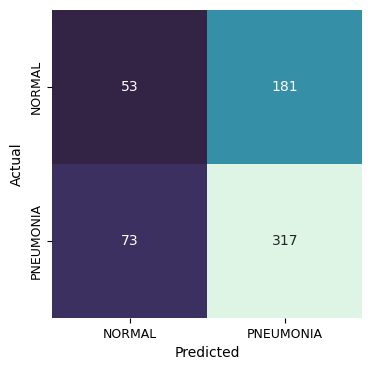

In [29]:
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='mako', cbar=False)
plt.xticks(np.arange(2) + 0.5, labels = ['NORMAL', 'PNEUMONIA'], fontsize=9)
plt.yticks(np.arange(2) + 0.5, labels = ['NORMAL', 'PNEUMONIA'], fontsize=9)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [15]:
results = model.evaluate(test_data, verbose=0)

accuracy = results[1]
auc = results[2]

2025-06-02 09:41:48.658399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


In [17]:
tn, tp, fn, fp = cm.ravel()

precision = tp / (tp + fp)
recall = tp / (tp + fn)

In [20]:
print("Accuracy: {:.2f}%".format(accuracy*100))
print("AUC: {:.2f}".format(auc))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

Accuracy: 79.49%
AUC: 0.92
Precision: 0.36
Recall: 0.71
